# LSTM model


In [20]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [21]:
!gcloud auth login

Go to the following link in your browser:

    https://accounts.google.com/o/oauth2/auth?code_challenge=ZMtvcgLJHHd5ENjrNBep0djPzZUSmf9E99JNJEPsf4M&prompt=select_account&code_challenge_method=S256&access_type=offline&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&client_id=32555940559.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fappengine.admin+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcompute+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth


Enter verification code: 4/vwGNvBpitcTYOHRumHohoxCI72HkF0s-etilfGXOt9RjMQKxCt-0EZo

You are now logged in as [galli.giuly@gmail.com].
Your current project is [None].  You can change this setting by running:
  $ gcloud config set project PROJECT_ID


In [22]:
%env GCLOUD_PROJECT=reddit-master

env: GCLOUD_PROJECT=reddit-master


In [23]:
import numpy as np 
import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import re
import plotly.graph_objs as go
import chart_studio.plotly as py
import cufflinks
import plotly.figure_factory as ff
import logging
import nltk
nltk.download('stopwords')
import keras.backend as K

from sklearn.metrics import classification_report, log_loss, accuracy_score, confusion_matrix
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Input
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))
from bs4 import BeautifulSoup
from plotly.offline import iplot
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')
from tensorflow import metrics, local_variables_initializer
from keras.models import load_model

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [24]:
# importing my final ds

!gsutil cp gs://reddit_final_results/reddit_clear_df.pkl .

Copying gs://reddit_final_results/reddit_clear_df.pkl...
- [1 files][253.2 MiB/253.2 MiB]                                                
Operation completed over 1 objects/253.2 MiB.                                    


In [0]:
model_LSTM_df = pd.read_pickle('reddit_clear_df.pkl')

In [26]:
# importing my final tokenizer

!gsutil cp gs://reddit_models/reddit_tokenizer.pkl .

Copying gs://reddit_models/reddit_tokenizer.pkl...
- [1 files][ 47.0 MiB/ 47.0 MiB]                                                
Operation completed over 1 objects/47.0 MiB.                                     


In [0]:
with open('reddit_tokenizer.pkl', 'rb') as file:
    tokenizer = pkl.load(file)

In [0]:
labels = model_LSTM_df['subreddit'].unique()

In [29]:
labels

array(['gaming', 'nba', 'europe', 'aww', 'movies', 'technology',
       'politics', 'Fitness', 'atheism', 'science'], dtype=object)

## Implementing the model

In [0]:
MAX_NB_WORDS = 75000
MAX_SEQUENCE_LENGTH = 450
EMBEDDING_DIM = 100

In [31]:
X = tokenizer.texts_to_sequences(model_LSTM_df['body'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (1546818, 450)


In [32]:
Y = pd.get_dummies(model_LSTM_df['subreddit']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (1546818, 10)


In [33]:
%%time

def train_dev_test_split(X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42, stratify=y_val)
    return (X_train,
                X_val,
                X_test,
                y_train,
                y_val,
                y_test)


X_train, X_val, X_test, Y_train, Y_val, Y_test = train_dev_test_split(X,Y)

print(X_train.shape,Y_train.shape)
print(X_val.shape,Y_val.shape)
print(X_test.shape,Y_test.shape)

(1082772, 450) (1082772, 10)
(232023, 450) (232023, 10)
(232023, 450) (232023, 10)
CPU times: user 20 s, sys: 18.4 s, total: 38.4 s
Wall time: 38.5 s


# Training with metric 'accuracy'

In [34]:
K.clear_session()

# Creating the neural network using Keras' functional api so that
# I'm able to inspect each one of the layers later.

inpt = Input(shape=(MAX_SEQUENCE_LENGTH,)) 
emb = Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1])(inpt)
dropout = SpatialDropout1D(0.2)(emb)
lstm = LSTM(30, dropout=0.2, recurrent_dropout=0.2)(dropout)
output = Dense(10, activation='softmax')(lstm)
model = Model(inputs =[inpt], outputs=[output])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 450)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 450, 100)          7500000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 450, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 30)                15720     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                310       
Total params: 7,516,030
Trainable params: 7,516,030
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
%%time

epochs = 10
batch_size = 150
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=1,
    min_delta=0.01)

history = model.fit(
    X_train,
    Y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val, Y_val),
    callbacks=[early_stopping]
)

Train on 1082772 samples, validate on 232023 samples
Epoch 1/10
1082772/1082772 [==============================] - 5560s 5ms/step - loss: 1.1229 - acc: 0.6416 - val_loss: 0.9688 - val_acc: 0.6916
Epoch 2/10
1082772/1082772 [==============================] - 5552s 5ms/step - loss: 0.9272 - acc: 0.7036 - val_loss: 0.9424 - val_acc: 0.6982
Epoch 3/10
1082772/1082772 [==============================] - 5535s 5ms/step - loss: 0.8700 - acc: 0.7198 - val_loss: 0.9390 - val_acc: 0.6987
CPU times: user 6h 29min 16s, sys: 24min 22s, total: 6h 53min 39s
Wall time: 4h 37min 27s


In [0]:
model.save('accuracy_model_lstm_30_batchsize_150_10_subreddits.h5')

In [0]:
!gsutil cp accuracy_model_lstm_30_batchsize_150_10_subreddits.h5 gs://reddit_models

Copying file://accuracy_model_lstm_30_batchsize_150_10_subreddits.h5 [Content-Type=application/octet-stream]...
\
Operation completed over 1 objects/86.0 MiB.                                     


In [35]:
# downloading the model

!gsutil cp gs://reddit_models/accuracy_model_lstm_30_batchsize_150_10_subreddits.h5 .

Copying gs://reddit_models/accuracy_model_lstm_30_batchsize_150_10_subreddits.h5...
\ [1 files][ 86.0 MiB/ 86.0 MiB]                                                
Operation completed over 1 objects/86.0 MiB.                                     


In [0]:
model = load_model("accuracy_model_lstm_30_batchsize_150_10_subreddits.h5")

In [53]:
%time

result = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(result[0],result[1]))

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.58 µs
232023/232023 [==============================] - 2221s 10ms/step
Test set
  Loss: 0.941
  Accuracy: 0.698


In [0]:
predictions = model.predict(X_test)

In [38]:
predictions

array([[4.12037317e-03, 3.07507329e-02, 3.35775912e-01, ...,
        4.45852764e-02, 4.44656238e-03, 7.39508774e-03],
       [3.37766088e-03, 1.15337044e-01, 5.00432122e-03, ...,
        3.20728645e-02, 1.85944773e-02, 1.09391231e-02],
       [1.45850517e-02, 5.03364205e-03, 2.67121494e-02, ...,
        2.03826651e-02, 5.56175001e-02, 2.90672872e-02],
       ...,
       [2.04406516e-03, 2.65429355e-03, 1.88630987e-02, ...,
        7.64956921e-02, 2.09458899e-02, 3.02390754e-01],
       [5.37829532e-04, 8.39697837e-04, 1.00572791e-03, ...,
        9.21291474e-04, 8.25681636e-05, 2.98280589e-04],
       [2.02734186e-03, 1.36381686e-01, 6.18974539e-03, ...,
        1.83902532e-01, 1.39610153e-02, 5.75380385e-01]], dtype=float32)

In [39]:
Y_test

array([[0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0]], dtype=uint8)

In [40]:
indices = np.argmax(predictions, axis=1)
predictions_oho = np.zeros((indices.size, indices.max()+1))
predictions_oho[np.arange(indices.size),indices] = 1

predictions_oho

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [41]:
print(classification_report(Y_test, predictions_oho, target_names=labels))

              precision    recall  f1-score   support

      gaming       0.85      0.88      0.86     23283
         nba       0.66      0.66      0.66     23284
      europe       0.68      0.73      0.71     23048
         aww       0.69      0.69      0.69     23284
      movies       0.68      0.65      0.67     23284
  technology       0.75      0.71      0.73     23284
    politics       0.81      0.82      0.81     23284
     Fitness       0.62      0.64      0.63     23128
     atheism       0.61      0.62      0.61     23062
     science       0.63      0.58      0.61     23082

   micro avg       0.70      0.70      0.70    232023
   macro avg       0.70      0.70      0.70    232023
weighted avg       0.70      0.70      0.70    232023
 samples avg       0.70      0.70      0.70    232023



# Visualization

In [0]:
conf = confusion_matrix(Y_test.argmax(axis=1), predictions.argmax(axis=1))

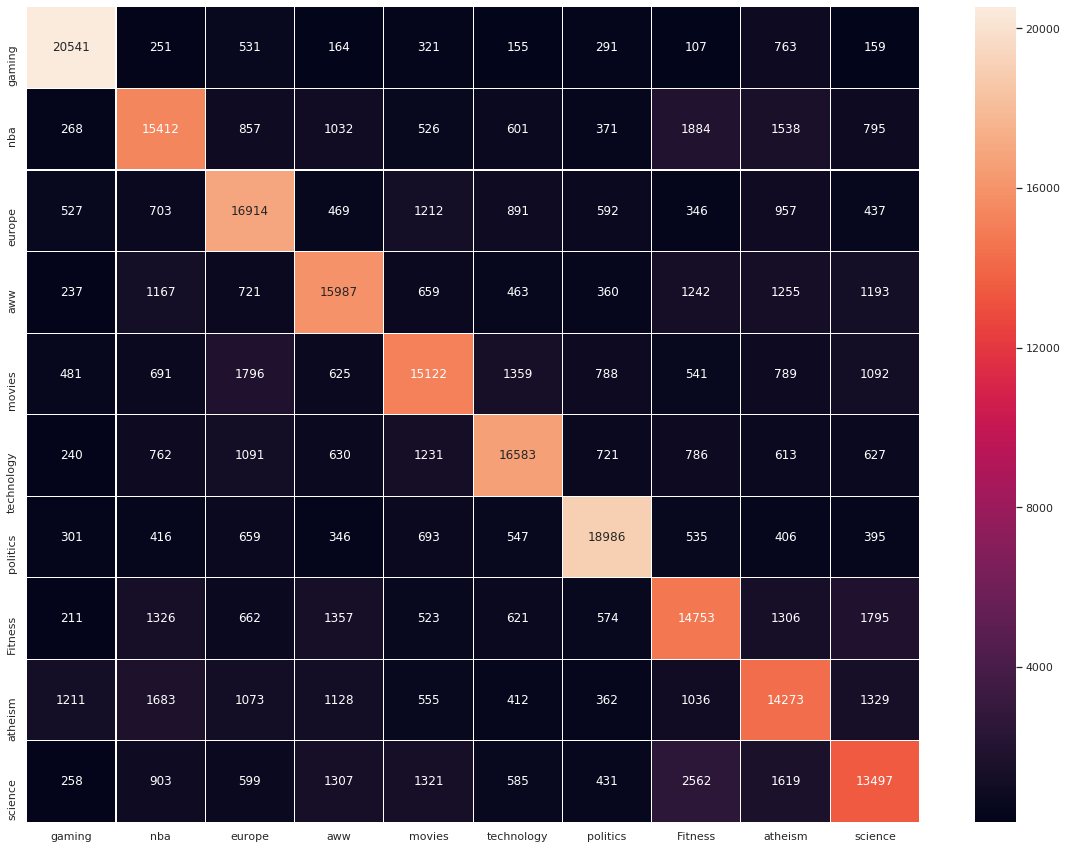

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

plt.figure(figsize =(20, 15))

sns.heatmap(conf, annot=True, linewidths=0.1, fmt='d', xticklabels=labels, yticklabels=labels)

# Testing on production

In [0]:
def label_decoder(subreddit):
    dict_labels = {
        0:"Fitness",
        1:"atheism",
        2:"aww",
        3:"europe",
        4:"gaming",
        5:"movies",
        6:"nba",
        7:"politics",
        8:"science",
        9:"technology"
    }
    
    return dict_labels[subreddit]

In [86]:
text = input("Please, enter the text of your blog: ") 
print("")
print("Text correctly entered, I'll give you that subreddit in a minute")

Please, enter the text of your blog: The Laboratory for Molecular Biology (LMB), clad in glass the color of sea ice, rises like a futuristic factory above the rapeseed fields of Cambridge, U.K. It is the crown jewel of the U.K. Medical Research Council, a storied government lab that has garnered more than a dozen Nobel Prizes. One of the first came in 1962 after LMB researchers, having pioneered x-ray crystallography, used the technique to decipher the first atomic structures for proteins—those of myoglobin and hemoglobin, which carry oxygen in muscle tissue and blood. X-ray crystallography has dominated structural biology ever since, but it has an Achilles’ heel: Some proteins just can’t be coaxed to form crystals, which scatter x-rays to reveal structure.

Text correctly entered, I'll give you that subreddit in a minute


In [87]:
MAX_NB_WORDS = 75000
MAX_SEQUENCE_LENGTH = 450
EMBEDDING_DIM = 100

X = tokenizer.texts_to_sequences([text])
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (1, 450)


In [88]:
result = model.predict(X)

def convert_to_cat(arr):
    biggest = 0
    for x in range(0, len(arr)):
        if arr[x] > arr[biggest]:
            biggest = x
    return biggest

category = [label_decoder(convert_to_cat(x)) for x in result]

print("you should publish your text into the sureddit: ", category)

you should publish your text into the sureddit:  ['science']
